In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import cv2
import torch

import numpy as np
import matplotlib.pylab as plt
import torch.optim as optim
import torch.nn.functional as F

from models.VQVAE2 import VQVAE2
from models.VQVAE import VQVAE
from config import setSeed, getConfig
from customLoader import MinecraftData, LatentBlockDataset

from pprint import pprint
from os.path import join
from pathlib import Path

from torchvision.utils import make_grid
from torchvision.transforms import transforms

from torch.utils.data import DataLoader

In [5]:
conf = {
  "experiment": "vqvae2_0",
  "environment": "MineRLNavigate-v0",
  "batch_size": 256,
  "num_training_updates": 25000,
  "learning_rate": 0.001,
  "split": 0.9,
  "vqvae": {
    "num_hiddens": 128,
    "num_residual_hiddens": 32,
    "num_residual_layers": 2,
    "embedding_dim": 64,
    "num_embeddings": 512,
    "commitment_cost": 0.25,
    "decay": 0.99
  },
  "pixelcnn": {
    "epochs": 100,
    "save": "no",
    "log_interval": 100,
    "lr": 0.0003,
    "img_dim": 16,
    "batch_size": 32,
    "num_hiddens": 64,
    "num_layers": 15,
    "gen_samples": "no"
  }
}

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
vqvae2 = VQVAE2().to(device)
vqvae2.eval()

VQVAE2(
  (enc_b): Encoder(
    (blocks): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ResBlock(
        (conv): Sequential(
          (0): ReLU(inplace=True)
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (6): ResBlock(
        (conv): Sequential(
          (0): ReLU(inplace=True)
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU(inplace=True)
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (7): ReLU(inplace=True)
    )
  )
  (enc_t): Encoder(
    (blocks): Sequential(
 

In [8]:
def showIndices(weights, valid_originals):
    weights_vqvae = torch.load(f"../../weights/{conf['experiment']}/{weights}.pt")['state_dict']
    vqvae2.load_state_dict(weights_vqvae)
    quant_t, quant_b, _, id_t, id_b, _, _ = vqvae2.encode(valid_originals)
    id_t = id_t.cpu().numpy()
    id_b = id_b.cpu().numpy()
    for indices in [id_t, id_b]:
        fig, ax = plt.subplots(2,8, figsize=(16,4))
        for j,i in enumerate(indices):
            ax[int(j/8), int(j%8)].imshow(i)
            ax[int(j/8), int(j%8)].axis('off')
            ax[int(j/8), int(j%8)].axis("tight")
        plt.show()
    
    return quant_t, quant_b


In [9]:
def showReconstruction(quant_t, quant_b):
    dec = vqvae2.decode(quant_t, quant_b)
    grid = make_grid(dec.cpu().data, normalize=True)
    fig, ax = plt.subplots(figsize=(16,4))
    plt.imshow(grid.permute(1,2,0).numpy())
    plt.axis('off')
    plt.show()

In [10]:
transform = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,0.5,0.5), (1.0,1.0,1.0))
                        ])


mrl_val = MinecraftData(conf['environment'], 'val', conf['split'], False, transform=transform, path='../../data')

validation_loader = DataLoader(mrl_val, batch_size=16, shuffle=True)

Loading data...


In [11]:
valid_originals = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

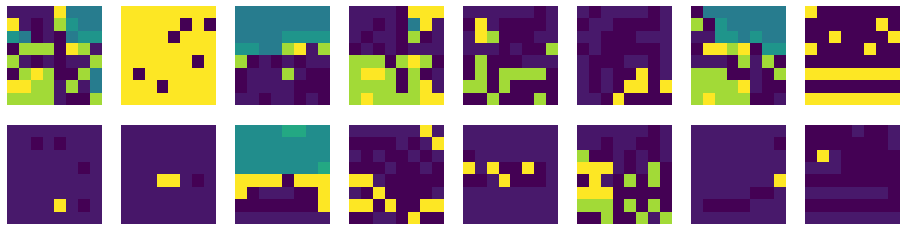

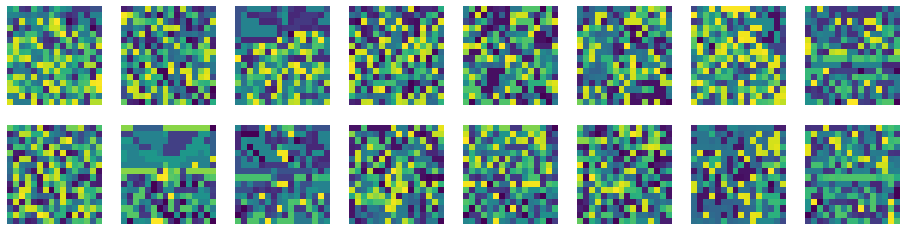

In [17]:
quant_t, quant_b = showIndices(10199, valid_originals)

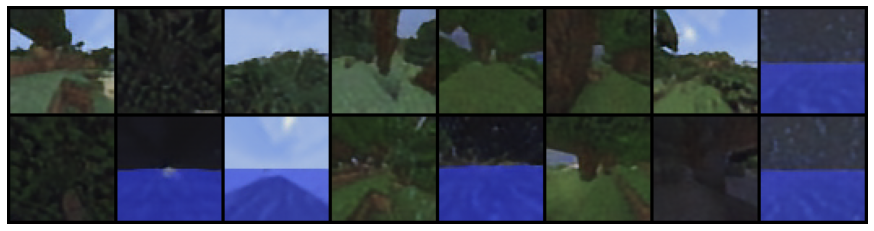

In [18]:
showReconstruction(quant_t, quant_b)

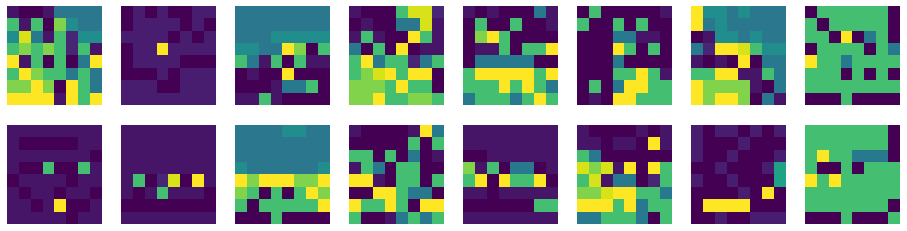

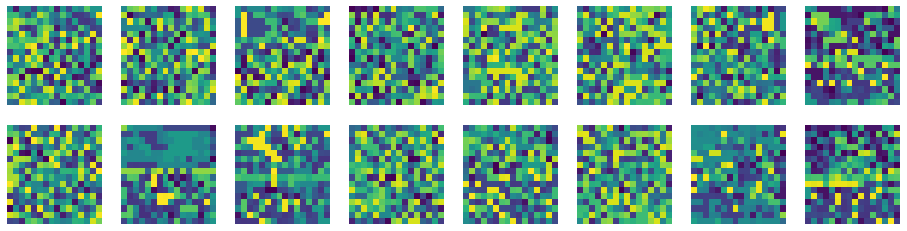

In [13]:
quant_t, quant_b = showIndices(18199, valid_originals)

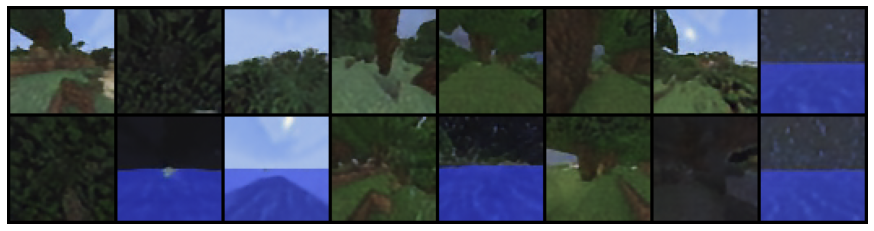

In [14]:
showReconstruction(quant_t, quant_b)

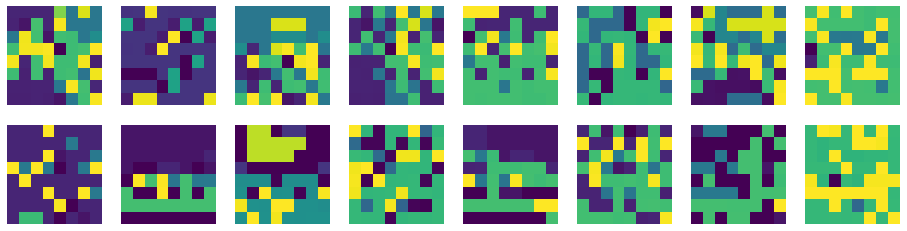

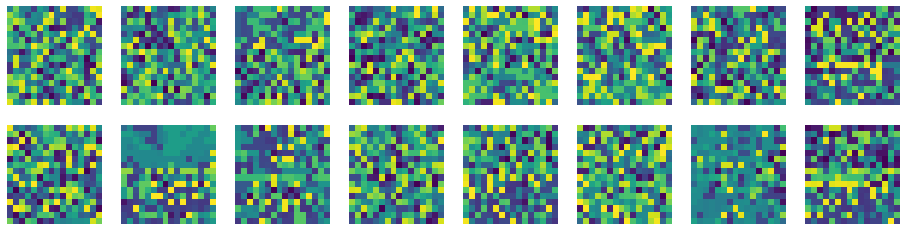

In [15]:
quant_t, quant_b = showIndices(23798, valid_originals)

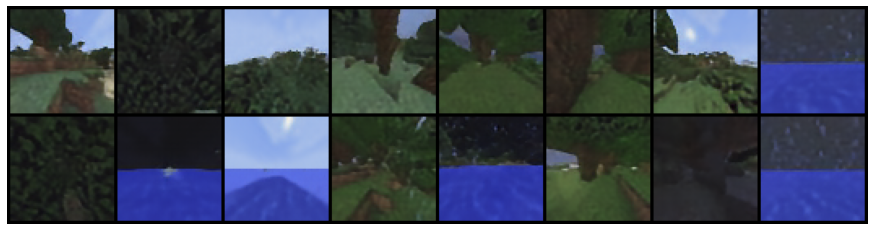

In [16]:
showReconstruction(quant_t, quant_b)

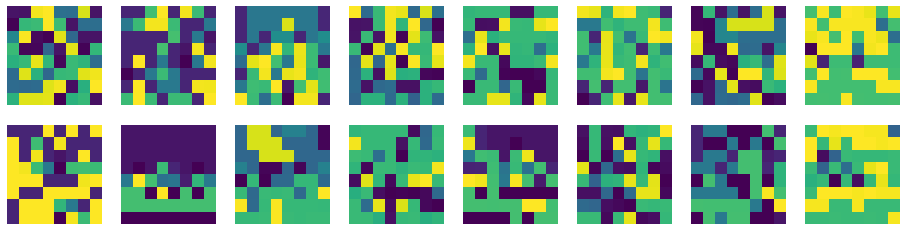

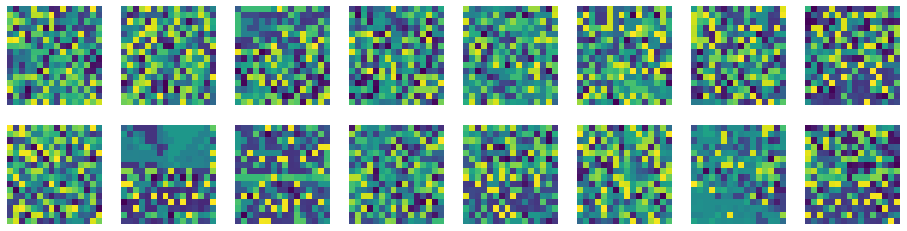

In [19]:
quant_t, quant_b = showIndices(27198, valid_originals)

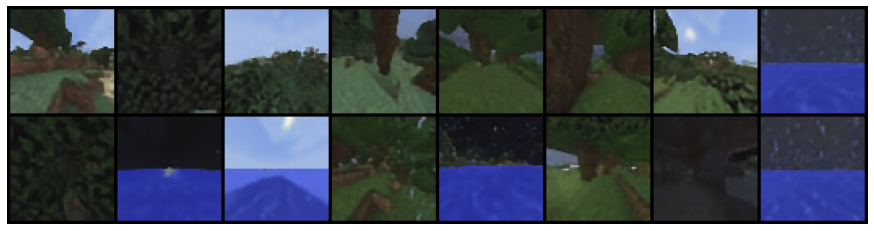

In [20]:
showReconstruction(quant_t, quant_b)